In [904]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats

In [1027]:
class ExpectedShortfall():
    
    def __init__(self, iterations, distribution = 'normal', correlatedReturns = True, esLevel = 5):
        """Set object attributes to given parameters.
        
        Parameters
        ----------
        iterations: integer
            Number of iterations of sampling from distribution.
            
        distribution: string
            Name of distribution to sample log-returns from. 
            
        correlated_returns: boolean
            Determines whether the covariance matrix of log-returns have nonzero elements outside diagonal or not.
            
        esLevel: float
            Confidence level for expected shortfall and value at risk.
        """
        
        self.iterations = iterations
        self.distribution = distribution
        self.df = 3
        self.means = np.array([0, 0, 0])
        self.esLevel = esLevel
        self.initialCapital = 10**5
        if correlatedReturns:
            self.cov = np.array([[1, 0.8, 0.1], [0.8, 1, 0.2], [0.1, 0.2, 1]])
        elif not correlatedReturns:
            self.cov = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        
    def exponential(self, vector):
        r1 = np.exp(0.03 + 0.01 * vector[0])
        r2 = np.exp(0.04 + 0.015 * vector[1])
        r3 = np.exp(0.05 + 0.02 * vector[2])
        out = [r1, r2, r3]
        return out 
    
    def simulation(self):
        self.normal_returns = np.random.multivariate_normal(self.means, self.cov, self.iterations)
        self.simulated_returns = []
        if self.distribution == 'normal':
            for i in range(self.iterations):
                self.simulated_returns.append(self.exponential(self.normal_returns[i]))
        elif self.distribution == 'students_t':
            for i in range(self.iterations):
                returns = self.exponential(self.t_transform(self.normal_returns[i], self.df))
                self.simulated_returns.append(returns)
    
    def t_transform(self, vector, df):
        transformed_vector = []
        for x in vector:
            fx = stats.t.ppf(stats.norm.cdf(x), df)
            transformed_vector.append(fx)
        return transformed_vector

    def es(self, weights):
        weights = np.divide(weights, np.sum(weights))
        portfolio_losses = []
        for i in range(self.iterations):
            portfolio_return = np.dot(weights, self.simulated_returns[i])
            portfolio_loss = -self.initialCapital * (portfolio_return * np.exp(-0.03) - 1)
            portfolio_losses.append(portfolio_loss)
        portfolio_losses = np.array(portfolio_losses)
        var = np.percentile(portfolio_losses, 100 - self.esLevel)
        norm_ = round(self.iterations * 0.01 * self.esLevel)
        sum_ = np.sum(portfolio_losses[portfolio_losses > var])
        es = sum_/norm_
        return es, portfolio_losses

    def objective_function(self, weights):
        es, _ = self.es(weights)
        return es
    
    def investment_constraint(self, weights):
        return np.sum(weights) - 1.0
    
    def minimize_es(self, portfolio_losses):
        bnds = [(0, 1), (0, 1), (0, 1)]
        cons = {'type': 'eq', 'fun': self.investment_constraint}
        initial_weights = [1/3, 1/3, 1/3]
        opt = minimize(self.objective_function, initial_weights, bounds = bnds, constraints = cons)
        return opt.x
                
    def plot_loss_distribution(self, portfolio_losses):
        n, bins, patches = plt.hist(x=portfolio_losses, bins='auto', range = (-6000, 4000))
        var = np.percentile(portfolio_losses, 100 - self.esLevel)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Loss')
        plt.ylabel('Frequency')
        plt.title('Histogram of Portfolio Losses')
        xlab = '95% Confidence VaR: ' + "{0:.2f}".format(var)
        plt.axvline(x=var, color = 'black', linestyle='--', label= xlab)
        plt.legend(loc='upper left')
        plt.show()
        

In [1028]:
def part_a():
    ES = ExpectedShortfall(iterations = 1000000, correlatedReturns = True, 
                           esLevel = 5, distribution = 'normal')
    portfolio_weights = [1/3, 1/3, 1/3]
    ES.simulation()
    es, portfolio_losses = ES.es(portfolio_weights)
    ES.plot_loss_distribution(portfolio_losses)
    print('{}% confidence Expected Shortfall: {}'.format(100-ES.esLevel, es))

In [1029]:
def part_b():
    ES = ExpectedShortfall(iterations = 1000000, correlatedReturns = False, 
                           esLevel = 5, distribution = 'normal')
    portfolio_weights = [1/3, 1/3, 1/3]
    ES.simulation()
    es, portfolio_losses = ES.es(portfolio_weights)
    ES.plot_loss_distribution(portfolio_losses)
    print('{}% confidence Expected Shortfall: {}'.format(100-ES.esLevel, es))

In [1030]:
def part_c():
    ES = ExpectedShortfall(iterations = 1000000, correlatedReturns = True, 
                           esLevel = 5, distribution = 'normal')
    ES.simulation()
    initial_weights = [1/3, 1/3, 1/3]
    initial_es, portfolio_losses = ES.es(initial_weights)
    optimal_weights = ES.minimize_es(portfolio_losses)
    minimal_es = ES.es(optimal_weights)[0]
    print('{}% confidence Expected Shortfall for optimal portfolio: {}'.format(100-ES.esLevel, minimal_es))
    print('Portfolio weights minimizing Expected Shortfall: {}'.format(optimal_weights))

In [1031]:
def part_d():
    ES = ExpectedShortfall(iterations = 1000000, correlatedReturns = True, 
                           esLevel = 5, distribution = 'students_t')
    portfolio_weights = [1/3, 1/3, 1/3]
    ES.simulation()
    es, portfolio_losses = ES.es(portfolio_weights)
    ES.plot_loss_distribution(portfolio_losses)
    print('{}% confidence Expected Shortfall: {}'.format(100-ES.esLevel, es))

In [ ]:
if __name__ == '__main__':
    part_a()
    part_b()
    part_c()
    part_d()

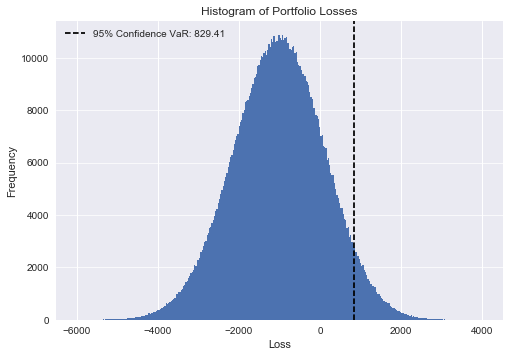

95% confidence Expected Shortfall: 1288.6281636800366


In [1032]:
part_a()

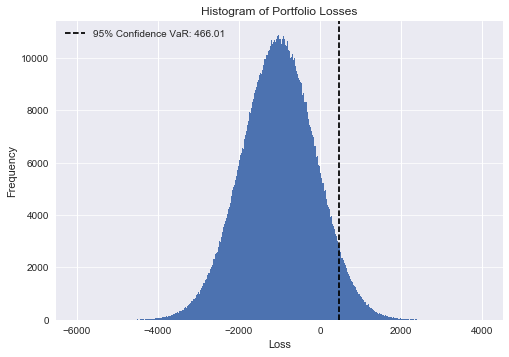

95% confidence Expected Shortfall: 839.9161903877527


In [1033]:
part_b()

In [1034]:
part_c()

95% confidence Expected Shortfall for optimal portfolio: 1265.2936106059306
Portfolio weights minimizing Expected Shortfall: [ 0.24357204  0.34816768  0.40826028]


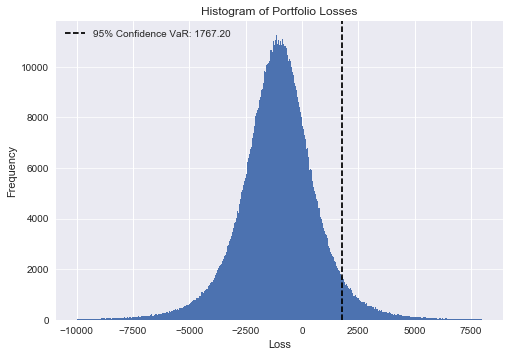

3187.07580738


In [1006]:
part_d()

In [833]:
xvalues = np.linspace(-5,5,1000)

In [857]:
normvalues = []
tvalues = []
stvalues = []
for i in range(1000):
    normvalues.append(stats.norm(0, 1).pdf(xvalues[i]))
    tvalues.append(ES.studentst_transform(norm(0, 1).pdf(xvalues[i]), 1))
    stvalues.append(stats.t.pdf(3, xvalues[i]))

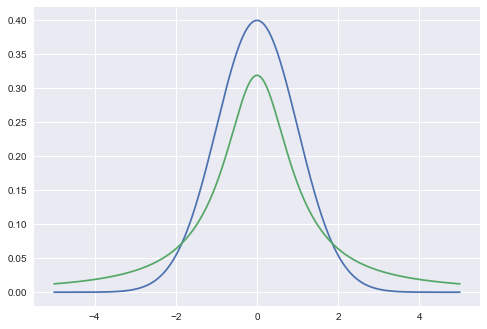

In [858]:
plt.plot(xvalues, normvalues)
plt.plot(xvalues, tvalues)
plt.show()

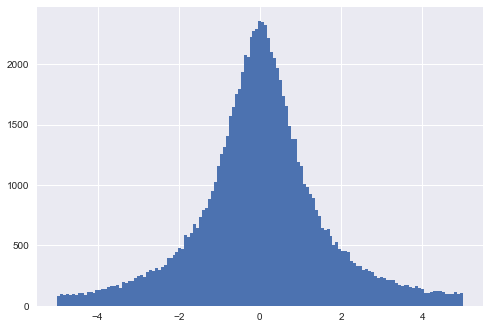

In [970]:
df = 1
values = []
xvalues = np.linspace(-5,5,100000)
for x in xvalues:
    values.append(stats.t.ppf(stats.norm.cdf(np.random.normal(0,1)), df))
plt.hist(values, bins = 'auto', range = (-5,5))
plt.show()

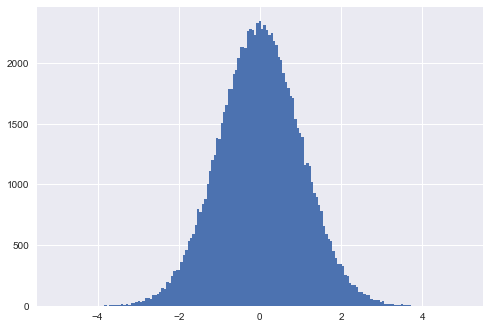

In [968]:
df = 100
values = []
xvalues = np.linspace(-5,5,100000)
for x in xvalues:
    values.append(stats.t.ppf(stats.norm.cdf(np.random.normal(0,1)), df))
plt.hist(values, bins = 'auto', range = (-5,5))
plt.show()